# Exploring the Boston Housing dataset

In this example, I explore various aspects of the Boston Housing dataset that is built into Python's sklearn library.
This aims to showcase: data wrangling, exploratory data analysis (EDA), supervised learning (feature selection, model selection, training and prediction)

To start, we'll do some imports:

In [1]:
% matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_boston
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score

## Preliminary EDA from Boston dataset
This section prints out some base information about the data we want to explore.

In [2]:
boston = load_boston()
print(type(boston))
print(boston.keys())
print(boston.data.shape)
print(boston.feature_names)

<class 'sklearn.utils.Bunch'>
dict_keys(['data', 'target', 'feature_names', 'DESCR'])
(506, 13)
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


From this it is observed that there are 506 data points and 13 data labels (features).  

The data lables are as follows:
[Information from UCI archive](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names)

Attribute Information:

|Attribute|Description                                                          |
|:--------|:-------------------------------------------------------------------:|
|CRIM     |per capita crime rate by town                                        |
|ZN       |proportion of residential land zoned for lots over 25,000 sq.ft.     |
|INDUS    |proportion of non-retail business acres per town                     |
|CHAS     |Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)|
|NOX      |nitric oxides concentration (parts per 10 million)                   |
|RM       |average number of rooms per dwelling                                 |
|AGE      |proportion of owner-occupied units built prior to 1940               |
|DIS      |weighted distances to five Boston employment centres                 |
|RAD      |index of accessibility to radial highways                            |
|TAX      |full-value property-tax rate per \$10,000                            |
|PTRATIO  |pupil-teacher ratio by town                                          |
|B        |1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town       |
|LSTAT    |% lower status of the population                                     |
|MEDV     |Median value of owner-occupied homes in $1000's                      |


## Using Pandas Data Frame for the Boston dataset
Creating a Data Frame from the Boston housing dataset will help speed up the analysis of this. 

In [3]:
boston_df = pd.DataFrame(boston.data, columns=boston.feature_names)
boston_df['MEDV'] = boston.target
boston_df.head(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7


## Some visual EDA
Here I aim to find some correlation using visual methods. The Seaborne package has some nice functions to do this. For this particular project, I used heatmap and pairplot. Note that for the pairplot, I selected only some of the highest correlated features to avoid overcrowding the figure.

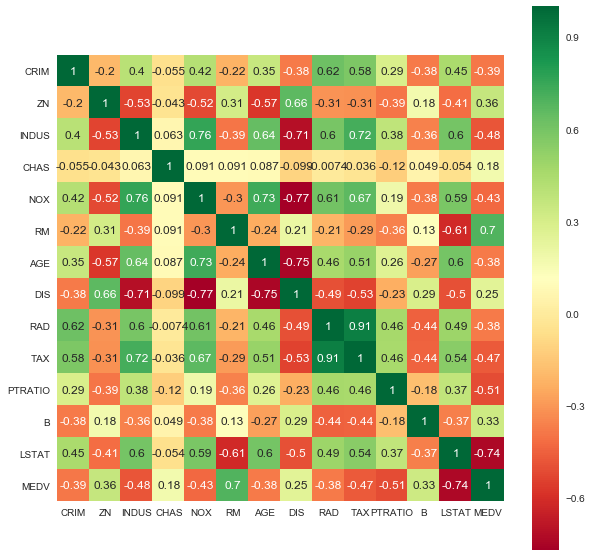

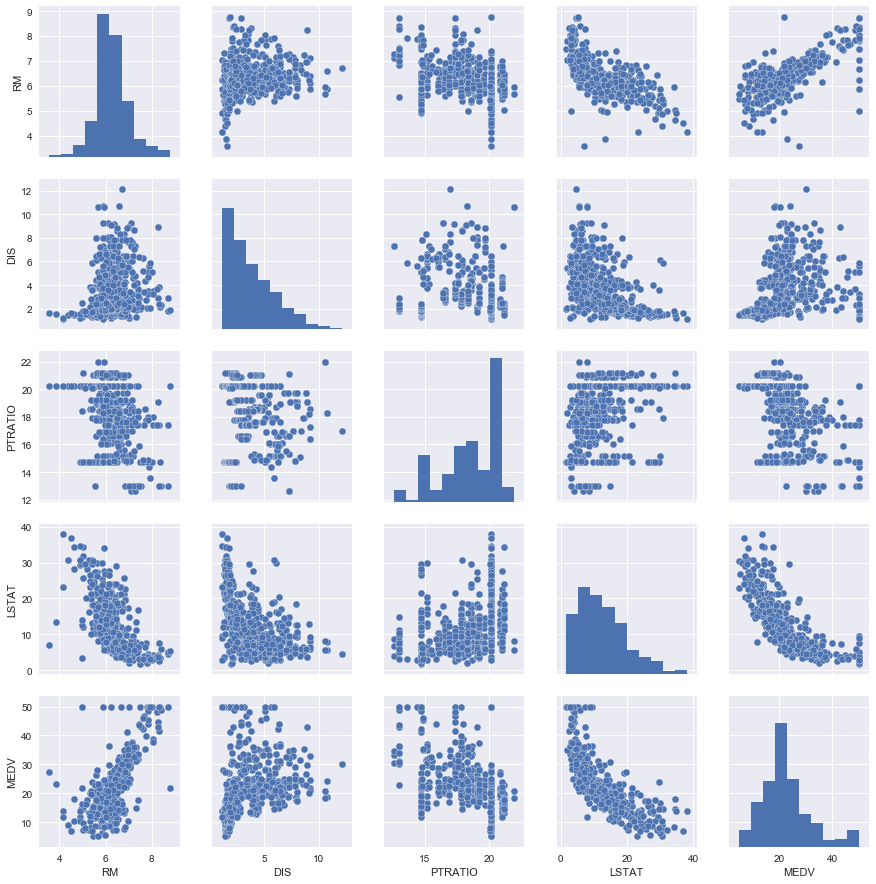

In [4]:
sns.set() #Sets Seaborn as the default plot style

fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(boston_df.corr(), annot=True, square=True, cmap='RdYlGn')
sns.pairplot(boston_df, vars=['RM', 'DIS', 'PTRATIO', 'LSTAT', 'MEDV']);

From the plots above, it can be seen that strong correlations exist with MEDV versus RM and LSTAT. PTRATIO and RM show some correlation to MEDV but it is not as strong as the other two mentioned. These features will likely be important with training the data for machine learning.

## Metrics of top features
In this section I explore the stastitics of the highest correlated features to get an idea of expected prediction values when training and testing.

In [5]:
boston_df[['RM', 'DIS', 'PTRATIO', 'LSTAT', 'MEDV']].describe()

,RM,DIS,PTRATIO,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000
mean,6.284634,3.795043,18.455534,12.653063,22.532806
std,0.702617,2.105710,2.164946,7.141062,9.197104
min,3.561000,1.129600,12.600000,1.730000,5.000000
25%,5.885500,2.100175,17.400000,6.950000,17.025000
50%,6.208500,3.207450,19.050000,11.360000,21.200000
75%,6.623500,5.188425,20.200000,16.955000,25.000000
max,8.780000,12.126500,22.000000,37.970000,50.000000


## Establishing the training model
Based on the sklearn [documentation](http://scikit-learn.org/stable/modules/tree.html), I choose a decision tree regressor as a learning model for these reasons:

- Simple to understand and to interpret. Trees can be visualised.  
- Requires little data preparation. Other techniques often require data normalisation, dummy variables need to be created and blank values to be removed. Note however that this module does not support missing values.

In [6]:
X = boston_df.drop('MEDV', axis=1)  # Features
y = boston_df['MEDV']  # Target (Price)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=2)

clf = DecisionTreeRegressor(random_state=2)
params = dict(max_depth=range(1, 11))

gs_cv = GridSearchCV(clf, params, cv=5)
gs_cv.fit(X_train, y_train)

print('Best parameters: {}'.format(gs_cv.best_params_))
print('R^2 score from test split: {:.3f}'.format(gs_cv.score(X_test, y_test)))

Best parameters: {'max_depth': 7}
R^2 score from test split: 0.795


## Predicting Values and Error Calculations
After fitting the data to training sets, we can now use the trained model to make predictions on the dataset.
This is achieved by using the the predict method on the trained model.  

Error calculations of mean absolute error (MAE) and R^2 will indicate how closely the predictions match the data and give an idea about under- or over-fitting a model. Plotting the residuals also help to visually identify the fit of the results.

In [7]:
y_train_pred = gs_cv.predict(X_train)
y_test_pred = gs_cv.predict(X_test)

print('MAE train: {:.3f}, test: {:.3f}'
      .format(mean_absolute_error(y_train, y_train_pred),
              mean_absolute_error(y_test, y_test_pred)))

print('R^2 score train: {:.3f}, test: {:.3f}'
      .format(r2_score(y_train, y_train_pred),
              r2_score(y_test, y_test_pred)))

MAE train: 1.289, test: 2.884
R^2 score train: 0.963, test: 0.795


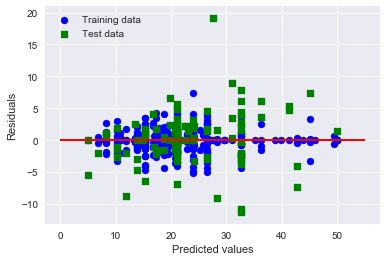

In [8]:
plt.scatter(y_train_pred, y_train_pred-y_train,
           c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred, y_test_pred-y_test,
           c='green', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=0, xmax=55, lw=2, color='red');

Based on these results, it appears that the model is slightly overfitting becuase the test error is higher than training set and the test R^2 is lower than the training set. However the model is still relatively good at predicting the interaction of this scenario based on the overall 0.795 R^2 for the test data.

## Feature Importance
Analyzing feature importance is useful in determining if your chosen model is behaving as predicted. If not, it may provide an insight as to where your analysis is being thrown off.

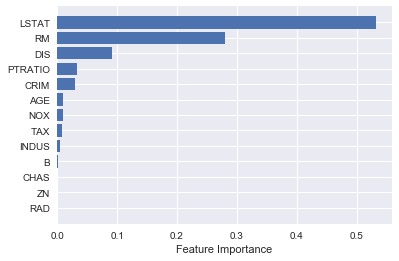

In [9]:
names = list(X.columns.values)
feature_importance = gs_cv.best_estimator_.feature_importances_
idx = np.argsort(feature_importance)
plt.figure()
plt.barh(np.arange(len(names)), feature_importance[idx])
plt.yticks(np.arange(len(names)), np.array(names)[idx])
plt.xlabel('Feature Importance');

From the graph, it is clear that LSTAT is the most impactful feature of this model, followed by RM, DIS and PTRATIO. This is in line with the earlier observations made using visual EDA.